In [10]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print("Tensorflow version is" + tf.__version__)
print(tf.test.gpu_device_name)

import keras
from keras import utils
from keras import preprocessing
from keras import applications
from keras import models
from keras import layers
from keras import optimizers

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Tensorflow version is1.13.1
<function gpu_device_name at 0x7fb345e14268>


In [0]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [0]:
def retrieve_data(data_url, verbose=False):

    if verbose:
        print('\nRetrieving data from',data_url,'...')

    zip_file_path = utils.get_file(
        origin=data_url,
        fname="cats_and_dogs_filtered.zip",
        extract=True
    )

    if verbose:
        print("Downloaded data to",zip_file_path)

    return zip_file_path

In [0]:
def split_data(base_dir, verbose=False):

    if verbose:
        print('\nSplitting data directories...')

    train_base_dir = os.path.join(base_dir, 'train')
    val_base_dir  = os.path.join(base_dir, 'validation')

    train_cats_dir = os.path.join(train_base_dir, 'cats')
    train_dogs_dir = os.path.join(train_base_dir, 'dogs')

    val_cats_dir = os.path.join(val_base_dir, 'cats')
    val_dogs_dir = os.path.join(val_base_dir, 'dogs')

    if verbose:
        print('Total cat training images: ',len(os.listdir(train_cats_dir)))
        print('Total dog training images: ',len(os.listdir(train_dogs_dir)))
        print('Total cat validation images:',len(os.listdir(val_cats_dir)))
        print('Total dog validation images:',len(os.listdir(val_dogs_dir)))

    path_list = [
        train_base_dir,
        val_base_dir,
        train_cats_dir,
        train_dogs_dir,
        val_cats_dir,
        val_dogs_dir
    ]

    return path_list

In [0]:
def create_generators(path_list, image_size, verbose=False):

    if verbose:
        print('\nCreating data generators...')

    batch_size = 32

    # Rescale the images so they're between 0 and 1 instead of [0,255]
    train_datagen = preprocessing.image.ImageDataGenerator(
        rescale=1./255
    )

    val_datagen = preprocessing.image.ImageDataGenerator(
        rescale=1./255
    )

    if verbose:
        print(train_datagen)
        print(val_datagen)

    # Create the generator. Similar to a dataloader in PyTorch,
    # allows us to feed into the network in batches.
    train_generator = train_datagen.flow_from_directory(
        directory=path_list[0],
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary'
    )

    val_generator = val_datagen.flow_from_directory(
        directory=path_list[1],
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary'
    )

    generators = [
        train_generator,
        val_generator
    ]

    return generators

In [0]:
def extract_features(base_model, verbose=False):

    # Feature extraction. Process for transfer learning:
    #       - Freeze convolutional base of network
    #       - Add classifier on top of conv base
    #       - Train only the top-level classifier

    if verbose:
        print('\nExtracting model features...')

    base_model.trainable = False

    if verbose:
        print(base_model.summary())

    headless_model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

    if verbose:
        print(headless_model.summary())

    return headless_model

In [0]:
def train(model, generators, verbose=False):

    if verbose:
        print('\nTraining the classifier...')
        for layer in model.layers:
            if layer.trainable:
                print('Layers to train:')
                print(layer)

    model.compile(
        optimizer=optimizers.RMSprop(lr=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    if verbose:
        print(model.summary())

    epochs = 5

    train_generator = generators[0]
    val_generator   = generators[1]

    steps_per_epoch =  train_generator.n
    validation_steps = val_generator.n

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        workers=8,
        validation_data=val_generator,
        validation_steps=validation_steps
    )
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8,8))

    plt.subplot(2,1,1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Acuracy')

    plt.subplot(2,1,2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0, max(plt.ylim())])
    plt.title('Training and Validation Loss')

    plt.show()

In [0]:
def finetune(model, generators, verbose=False):
    
  # Break out the first layer of our model which is the original base model
  base_model = model.layers[0]
  base_model.trainable = True
  
  if verbose:
      print('Number of layers in the base model: ', len(base_model.layers))
    
  finetune_at = 100
  
  for layer in base_model.layers[:finetune_at]:
      layer.trainable = False
    
  model.compile(
      loss='binary_crossentropy',
      optimizer=optimizers.RMSprop(lr=2e-5),
      metrics=['accuracy']
  )
  
  if verbose:
      model.summary()
      
  epochs = 5    
      
  train_generator = generators[0]
  val_generator   = generators[1]
  
  steps_per_epoch =  train_generator.n
  validation_steps = val_generator.n
    
  history_fine = model.fit_generator(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs=epochs, 
      workers=8,
      validation_data=val_generator, 
      validation_steps=validation_steps
  )
  
  acc += history_fine.history['acc']
  val_acc += history_fine.history['val_acc']

  loss += history_fine.history['loss']
  val_loss += history_fine.history['val_loss']
  
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylim([0.9, 1])
  plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.ylim([0, 0.2])
  plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

Beginning transfer learning program...

Retrieving data from https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip ...
Downloaded data to /root/.keras/datasets/cats_and_dogs_filtered.zip

Splitting data directories...
Total cat training images:  1000
Total dog training images:  1000
Total cat validation images: 500
Total dog validation images: 500

Creating data generators...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.

Extracting model features...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]              

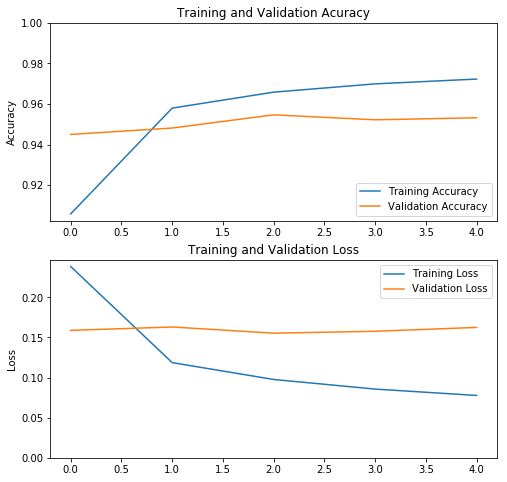

Number of layers in the base model:  155
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________
Epoch 1/5
2000/2000 [==============================] - 269s 134ms/step - loss: 0.0095 - acc: 0.9970 - val_loss: 0.1209 - val_acc: 0.9778
Epoch 2/5
2000/2000 [==============================] - 265s 132ms/step - loss: 4.9424e-04 - acc: 0.9999 - val_loss: 0.1359 - val_acc: 0.9740
Epoch 3/5
2000/2000 [==============================] - 264s 132ms/step 

UnboundLocalError: ignored

In [18]:
# Main Function

print("Beginning transfer learning program...")

verbose = True

# Useful persisting variables
image_size = 160

# Retrieve the Kaggle Competition cats and dogs dataset.
data_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_file_path = retrieve_data(data_url, verbose)
base_dir, _ = os.path.splitext(zip_file_path)

# Create training and test sets
path_list = split_data(base_dir, verbose)

# Preprocess the raw images using ImageDataGenerator
generators = create_generators(path_list, image_size, verbose)

# Create the pretrained base model.
# Using MobileNet V2 pretrained on ImageNet.
# Important caveat for transfer learning: include_top=False
base_model = applications.MobileNetV2(
    input_shape=(image_size, image_size, 3),
    include_top=False,
    weights='imagenet'
)

headless_model = extract_features(base_model, verbose)

# Train the top layers of the model
train(headless_model, generators, verbose)
headless_model.save('untuned_cat_dog.model')

# Finetune the model
finetune(headless_model, generators, verbose)
headless_model.save('finetuned_cat_dog.model')